In [79]:
#Libraries
#big test
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [56]:
#Load the datasets

#This function retrieves the list of text files (which are all indivudial arguments) and compiles them into a dataframe
def get_arguments_from_text():
    path = "/Users/danielbradley/Documents/FlatIron/Phase5/Sophie-Debate-Bot/data/no_wavs/trs.txt"
    os.chdir(path)
    list_of_files = []

    # iterate through all file
    for file in os.listdir():
        list_of_files.append(file)

    #Create a list of arguments as strings
    list_of_strings = []
    for file in list_of_files:
        with open(path+'/'+file) as f:
            list_of_strings.append(f.read())

    #Turn the list into a dataframe
    return pd.DataFrame(list_of_strings, columns=['argument'])

#1: Argument detection dataset
dataset_arg_detect = pd.read_csv('data/IBM_Debater_(R)_ArgsInASR_Findings-2020.v1/argumentative_sentences_in_spoken_language_with split.csv')
dataset_arg_detect_train = pd.read_csv('data/IBM_Debater_(R)_ArgsInASR_Findings-2020.v1/data_sets/q_mc_train.csv')
dataset_arg_detect_test = pd.read_csv('data/IBM_Debater_(R)_ArgsInASR_Findings-2020.v1/data_sets/q_mc_test.csv')
dataset_arg_detect_wiki = pd.read_csv('data/IBM_Debater_(R)_ArgsInASR_Findings-2020.v1/wikipedia_evidence_dataset_29429.csv')

#2: Data quality dataset - test and train
dataset_arg_qual_train = pd.read_csv('data/IBM_Debater_(R)_EviConv-ACL-2019.v1/train.csv')
dataset_arg_qual_test = pd.read_csv('data/IBM_Debater_(R)_EviConv-ACL-2019.v1/test.csv')

#3: Argument stance detection dataset
dataset_arg_stance = pd.read_csv('data/IBM_Debater_(R)_CS_EACL-2017.v1/claim_stance_dataset_v1.csv')

#4: Debater analysis dataset
dataset_arg_gen = pd.read_csv('data/no_wavs/RecordedDebatingDataset_Release5_metadata.csv')
dataset_arg_gen_ootec = pd.read_csv('data/no_wavs/OutOfTheEchoChamber_acl2020_split.csv')

owd = os.getcwd()
dataset_arg_gen_args = get_arguments_from_text()
os.chdir(owd)

#5: Key point analysis: Arg KP dataset
dataset_key_point = pd.read_csv('data/IBM_Debater_(R)_ArgKP-2021/ArgKP-2021_dataset.csv')

#6: Claim generation: Must be able to generate claims
dataset_claim_gen = pd.read_csv('data/IBM_Debater_(R)_ GPT-2_Claim_Generation/generated_texts_plausibility_stance.csv')

## Dataset #1: Domain detection
What topic is the debater discussing? The model must be able to determine this accurately to access the correct class of responses.

- a. The dataset: motion-evidence samples taken from Wikipedia with acceptance rate scored from 0-1 (acceptance rate being confidence that the text contains evidence for the motion)
- b. over 29,000 evidence claims with relevant motion and concept

Goals of the model: Should be able to determine which topic is being discussed and whether the sentence contains evidence on the motion or not

In [16]:
#Generating the relevant target and feature columns. The data  column is both the motion and evidence, as this helps the model train on a GIVEN topic (see Liat Ein-Dor et al., 2020)

dataset_arg_detect_wiki['target'] = dataset_arg_detect_wiki['acceptanceRate'].apply(lambda x: 1 if x > 0.5 else 0)
dataset_arg_detect_wiki = dataset_arg_detect_wiki.drop(columns= ['Wikipedia article_id', 'Wikipedia article_title'])
dataset_arg_detect_wiki['data'] = dataset_arg_detect_wiki['Evidence'] + ' ' + dataset_arg_detect_wiki['Motion Text']

In [17]:
dataset_arg_detect_wiki.sort_values(by = 'acceptanceRate', ascending=True).loc[dataset_arg_detect_wiki['Dominant Concept'] == 'Doping in sport'][:]

,Motion Text,Dominant Concept,Evidence,acceptanceRate,target,data
145,We should legalize doping in sport,Doping in sport,A routine unannounced drug test found the bann...,0.0,0,A routine unannounced drug test found the bann...
154,We should legalize doping in sport,Doping in sport,A report by a joint International Swimming Fed...,0.0,0,A report by a joint International Swimming Fed...
155,We should legalize doping in sport,Doping in sport,"In his book Clearing the Bases, he said that a...",0.0,0,"In his book Clearing the Bases, he said that a..."
160,We should legalize doping in sport,Doping in sport,Matthew Syed countered that while the incident...,0.0,0,Matthew Syed countered that while the incident...
166,We should legalize doping in sport,Doping in sport,After Landis' A sample tested positive for tes...,0.0,0,After Landis' A sample tested positive for tes...
...,...,...,...,...,...,...
77,We should legalize doping in sport,Doping in sport,"It is estimated that around 10,000 former athl...",1.0,1,"It is estimated that around 10,000 former athl..."
152,We should legalize doping in sport,Doping in sport,Another point of view is that doping could be ...,1.0,1,Another point of view is that doping could be ...
80,We should legalize doping in sport,Doping in sport,A recent study has also shown that long term A...,1.0,1,A recent study has also shown that long term A...
112,We should legalize doping in sport,Doping in sport,"A 2005 review in CNS Drugs determined that ""si...",1.0,1,"A 2005 review in CNS Drugs determined that ""si..."


In [68]:
article_num = 112
print(dataset_arg_detect_wiki.iloc[article_num,2], dataset_arg_detect_wiki.iloc[article_num,4])
nlp(dataset_arg_detect_wiki.iloc[article_num,2]).cats

A 2005 review in CNS Drugs determined that "significant psychiatric symptoms including aggression and violence, mania, and less frequently psychosis and suicide have been associated with steroid abuse 19218324


/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


{'LABEL': 0.24414502084255219, 'NOT_LABEL': 0.7558550238609314}

### Model training is done on Google Colab. Re-import here when it's complete.

In [57]:
#Import the trained google colab model
import spacy
nlp_baseline = spacy.load('models/arg_detect_sample_model')
nlp = spacy.load('models/arg_detect_full_model_transformer')

In [63]:
# This cell was run to load in the dataset initially. Re-load using same file

# dev_df = pd.read_csv('processed_data/arg_detect_test.csv')
# dev_df['pred'] = dev_df['feature'].apply(lambda x: 1 if nlp(x).cats['LABEL'] > 0.5 else 0)
# dev_df.head()
# dev_df.to_csv('processed_data/arg_detect_test_df.csv')

/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


,Unnamed: 0,feature,target,pred
0,0,"In the plan, the Obama Administration responds...",1,1
1,1,"Spooner's essay ""No Treason""[REF] offers an in...",0,0
2,2,Due to the high number of high-profile urban o...,0,1
3,3,After a long humbling year temping as a traffi...,0,0
4,4,Fenn claimed that he owned the technology beca...,0,0


In [19]:
dev_df = pd.read_csv('processed_data/arg_detect_test_df.csv').drop(columns= ['Unnamed: 0', 'Unnamed: 0.1']).rename(columns={'pred': 'pred_full'})
dev_df['pred_baseline'] = dev_df['feature'].apply(lambda x: 1 if nlp_baseline(x).cats['argumentative'] > 0.5 else 0)
dev_df.head()

,feature,target,pred_full,pred_baseline
0,"In the plan, the Obama Administration responds...",1,1,0
1,"Spooner's essay ""No Treason""[REF] offers an in...",0,0,0
2,Due to the high number of high-profile urban o...,0,1,1
3,After a long humbling year temping as a traffi...,0,0,0
4,Fenn claimed that he owned the technology beca...,0,0,0


In [26]:
dev_df['target'].value_counts()

0    4437
1    1449
Name: target, dtype: int64

### Run for the baseline model

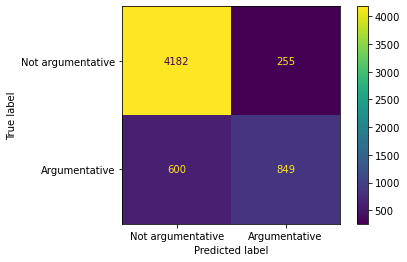

In [182]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
conf = confusion_matrix(dev_df['target'], dev_df['pred_baseline'])
disp = ConfusionMatrixDisplay(conf, display_labels = ['Not argumentative', 'Argumentative'])
disp.plot()
plt.savefig('figures/arg_detect_baseline.png', transparent=True, dpi = 800, bbox_inches='tight');

### Run again for the full model

<Figure size 432x288 with 0 Axes>

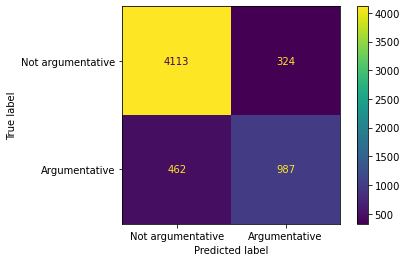

In [156]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
conf = confusion_matrix(dev_df['target'], dev_df['pred_full'])
disp = ConfusionMatrixDisplay(conf, display_labels = ['Not argumentative', 'Argumentative'])
plt.savefig('figures/arg_detect_baseline.png', transparent=True, dpi = 800, bbox_inches='tight');
disp.plot()
plt.savefig('figures/arg_detect_full.png', transparent=True, dpi = 800, bbox_inches='tight');

In [25]:
print('Baseline model report:')
print('')
print(classification_report(dev_df['target'], dev_df['pred_baseline']))
print('')
print('Full model report:')
print('')
print(classification_report(dev_df['target'], dev_df['pred_full']))

Baseline model report:

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      4437
           1       0.77      0.59      0.67      1449

    accuracy                           0.85      5886
   macro avg       0.82      0.76      0.79      5886
weighted avg       0.85      0.85      0.85      5886


Full model report:

              precision    recall  f1-score   support

           0       0.90      0.93      0.91      4437
           1       0.75      0.68      0.72      1449

    accuracy                           0.87      5886
   macro avg       0.83      0.80      0.81      5886
weighted avg       0.86      0.87      0.86      5886



### Conclusion
The full model appears to perform better on the argumentative set (the positive case) than the baseline model. More training should be done on the full model since only one epoch was completed on the full model and will certainly improve with further training.

In [158]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
roc_auc_score(dev_df['target'], dev_df['pred_full'])

0.8040685539583149

In [179]:
# Compute ROC curve and ROC area for each class
y_test = list(dev_df['target'])
y_score = list(dev_df['pred_full'])

y = label_binarize(y_test, classes=[0, 1])
n_classes = y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

In [180]:
# Compute ROC curve and ROC area for each class for BASELINE
y_test = list(dev_df['target'])
y_score = list(dev_df['pred_baseline'])

y = label_binarize(y_test, classes=[0, 1])
n_classes = y.shape[1]

fpr_base = dict()
tpr_base = dict()
roc_auc_base = dict()
fpr_base, tpr_base, _ = roc_curve(y_test, y_score)
roc_auc_base = auc(fpr_base, tpr_base)

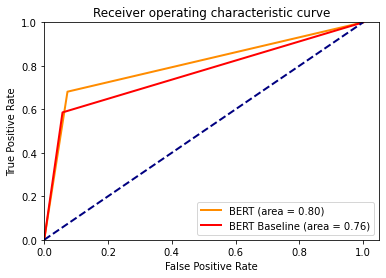

<Figure size 432x288 with 0 Axes>

In [181]:
fig, ax = plt.subplots()
plt.figure()
lw = 2
ax.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="BERT (area = %0.2f)" % roc_auc,
)
ax.plot(
    fpr_base,
    tpr_base,
    color="red",
    lw=lw,
    label="BERT Baseline (area = %0.2f)" % roc_auc_base,
)
ax.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
ax.set_ylim([0.0, 1.0])
ax.set_xlim([0.0, 1.05])
ax.set_ylabel("True Positive Rate")
ax.set_xlabel("False Positive Rate")
ax.set_title("Receiver operating characteristic curve")
ax.legend(loc="lower right")
fig.savefig('figures/arg_detect_roc_auc.png', transparent=True, dpi = 800, bbox_inches='tight');

## Dataset #2: Argument quality

In [10]:
dataset_arg_qual_train.head()

,topic,evidence_1,evidence_2,label,acceptance_rate,evidence_1_stance,evidence_2_stance,evidence_1_detection_score,evidence_2_detection_score,evidence_1_id,evidence_2_id,evidence_1_wikipedia_article_name,evidence_2_wikipedia_article_name,evidence_1_wikipedia_url,evidence_2_wikipedia_url
0,We should end affirmative action,"In February 2007, Sarkozy appeared on a televi...",Williams believes programs such as affirmative...,2,1.00,CON,PRO,0.340517,0.469968,2469,2478,Nicolas Sarkozy,Walter E. Williams,https://en.wikipedia.org/wiki/Nicolas_Sarkozy,https://en.wikipedia.org/wiki/Walter_E._Williams
1,We should subsidize condoms,"In 2009, Lewis strongly criticized Pope Benedi...","Green said that according to the ""best studies...",2,0.63,PRO,CON,0.903295,0.861465,1743,1750,Stephen Lewis,HIV/AIDS in the Philippines,https://en.wikipedia.org/wiki/Stephen_Lewis,https://en.wikipedia.org/wiki/HIV/AIDS_in_the_...
2,We should legalize prostitution,"The appellants' argument then, more precisely ...",Feminists who hold such views on prostitution ...,1,0.71,CON,CON,0.644333,0.674035,1564,1608,Prostitution in Canada,Feminism,https://en.wikipedia.org/wiki/Prostitution_in_...,https://en.wikipedia.org/wiki/Feminism
3,We should adopt socialism,As a model for the development of post-colonia...,Lange and Lerner also admitted that socialism ...,1,0.67,CON,CON,0.607890,0.543936,3517,3530,Randolph Foundation,Economic calculation problem,https://en.wikipedia.org/wiki/Randolph_Foundation,https://en.wikipedia.org/wiki/Economic_calcula...
4,We should prohibit corporal punishment,The research that is available supports the po...,"In November 2009, the government of the People...",1,0.90,PRO,PRO,0.641014,0.727950,3384,3393,Corporal punishment in the home,Internet addiction disorder,https://en.wikipedia.org/wiki/Corporal_punishm...,https://en.wikipedia.org/wiki/Internet_addicti...


In [43]:
dataset_arg_qual_train = dataset_arg_qual_train[['evidence_1', 'evidence_2', 'label', 'acceptance_rate', 'evidence_1_detection_score', 'evidence_2_detection_score']]

In [ ]:
dataset_arg_qual_train.iloc[4,:][1]

: 

In [67]:
dataset_arg_qual_train.iloc[0,:][2]

'Williams believes programs such as affirmative action and minimum wage laws set up to aide minorities have, in fact, been harmful to them and stifled their ability to advance in society.'

### The problem:

The dataset is structured as follows:

FEATURES:
There are two features, either of which can be for or against a given motion. The feature is a statement making an argument about some motion with supporting evidence.

OUTPUT:
The desired output is a convincingness score for a single document, 1 being convincing and 0 being not convincing.

#### Implementation:
Create a siamese neural network where each leg of the network is a Bidirectional LSTM model. Then apply a softmax on the outputs of both models to determine which one is more convincing. Use a dummy score placeholder to look at the convincingness of a single statement.

## Dataset #3: Argument stance detection
The full BERT model was trained in a Google Colab notebook as a GPU was needed to refine the transformer. The GPU was a Tesla T4 with 16GB of VRAM and the model ran for 7 hours, 2 minutes, and 47 seconds. The model built 119 epochs before it was aborted early as the model converged by epoch ~25.

Link: https://colab.research.google.com/drive/1tZ0tOJn5gFho3tUBOwPpgszz4GUsy1iQ#scrollTo=OajL670RVqr3

In [69]:
dataset_arg_stance.head()

,topicId,split,topicText,topicTarget,topicSentiment,claims.claimId,claims.stance,claims.claimCorrectedText,claims.claimOriginalText,claims.article.rawFile,...,claims.article.rawSpan.end,claims.article.cleanFile,claims.article.cleanSpan.start,claims.article.cleanSpan.end,claims.Compatible,claims.claimTarget.text,claims.claimTarget.span.start,claims.claimTarget.span.end,claims.claimSentiment,claims.targetsRelation
0,1,test,This house believes that the sale of violent v...,the sale of violent video games to minors,-1,2973,PRO,Exposure to violent video games causes at leas...,exposure to violent video games causes at leas...,articles/t1/raw_1.txt,...,640,articles/t1/clean_1.txt,418,568,yes,Exposure to violent video games,0.0,31.0,-1.0,1.0
1,1,test,This house believes that the sale of violent v...,the sale of violent video games to minors,-1,2974,CON,video game violence is not related to serious ...,video game violence is not related to serious ...,articles/t1/raw_1.txt,...,1697,articles/t1/clean_1.txt,829,907,yes,video game violence,0.0,19.0,1.0,1.0
2,1,test,This house believes that the sale of violent v...,the sale of violent video games to minors,-1,2975,CON,some violent video games may actually have a p...,some violent video games may actually have a p...,articles/t1/raw_1.txt,...,2089,articles/t1/clean_1.txt,1004,1082,yes,some violent video games,0.0,24.0,1.0,1.0
3,1,test,This house believes that the sale of violent v...,the sale of violent video games to minors,-1,2977,PRO,exposure to violent video games causes both sh...,exposure to violent video games causes both sh...,articles/t1/raw_1.txt,...,3695,articles/t1/clean_1.txt,1442,1577,yes,exposure to violent video games,0.0,31.0,-1.0,1.0
4,1,test,This house believes that the sale of violent v...,the sale of violent video games to minors,-1,2978,PRO,Violent video games increase the violent tende...,they increase the violent tendencies among youth,articles/t1/raw_1.txt,...,8167,articles/t1/clean_1.txt,3900,3948,yes,Violent video games,0.0,19.0,-1.0,1.0


In [184]:
dataset_arg_stance.iloc[0,2]

'This house believes that the sale of violent video games to minors should be banned'

In [72]:
#BERT model was trained using spacy configurations detailed in google colab notebook linked above
import spacy
nlp_claim_full = spacy.load('models/claim_stance_full')

claim_test_df = pd.read_csv('processed_data/claim_stance/test.csv', index_col=0)
claim_test_df['pred'] = claim_test_df['feature'].apply(lambda x: 0 if nlp_claim_full(x).cats['LABEL'] < 0.5 else 1)

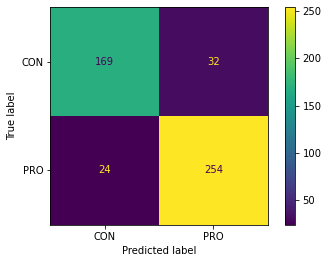

In [165]:
conf = confusion_matrix(claim_test_df['target'], claim_test_df['pred'])
disp = ConfusionMatrixDisplay(conf, display_labels = ['CON', 'PRO'])
disp.plot()
plt.savefig('figures/claim_stance_full.png', transparent=True, dpi = 800, bbox_inches='tight');

In [81]:
print('Full model report:')
print('')
print(classification_report(claim_test_df['target'], claim_test_df['pred']))

Full model report:

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       201
           1       0.89      0.91      0.90       278

    accuracy                           0.88       479
   macro avg       0.88      0.88      0.88       479
weighted avg       0.88      0.88      0.88       479



### Traditional method using a basic tree classifier
This was done on a Google Colab notebook as there were compatibility issues on my M1 Macbook. A decision tree classifier was used for this baseline.

link: https://colab.research.google.com/drive/15xhegG4ubWHkic6cxK1v9hnphqBgS3DI#scrollTo=Sw61DdKdjvT4

In [120]:
#Import the predicted results
pred_baseline_df = pd.read_csv('processed_data/claim_stance/pred_baseline_dt.csv', index_col=0)
claim_test_df['pred_baseline'] = pred_baseline_df

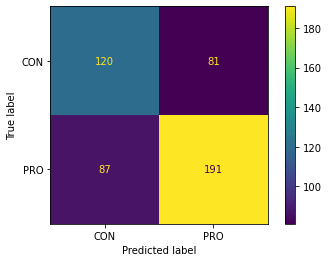

In [166]:
conf = confusion_matrix(claim_test_df['target'], claim_test_df['pred_baseline'])
disp = ConfusionMatrixDisplay(conf, display_labels = ['CON', 'PRO'])
disp.plot()
plt.savefig('figures/claim_stance_baseline.png', transparent=True, dpi = 800, bbox_inches='tight');

In [122]:
print('Baseline model report:')
print('')
print(classification_report(claim_test_df['target'], claim_test_df['pred_baseline']))

Baseline model report:

              precision    recall  f1-score   support

           0       0.58      0.60      0.59       201
           1       0.70      0.69      0.69       278

    accuracy                           0.65       479
   macro avg       0.64      0.64      0.64       479
weighted avg       0.65      0.65      0.65       479



### Metrics

In [167]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
roc_auc_score(claim_test_df['target'], claim_test_df['pred'])

0.8772325423243496

In [174]:
# Compute ROC curve and ROC area for each class
y_test = list(claim_test_df['target'])
y_score = list(claim_test_df['pred'])

y = label_binarize(y_test, classes=[0, 1])
n_classes = y.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

In [175]:
# Compute ROC curve and ROC area for each class for BASELINE
y_test = list(claim_test_df['target'])
y_score = list(claim_test_df['pred_baseline'])

y = label_binarize(y_test, classes=[0, 1])
n_classes = y.shape[1]

fpr_base = dict()
tpr_base = dict()
roc_auc_base = dict()
fpr_base, tpr_base, _ = roc_curve(y_test, y_score)
roc_auc_base = auc(fpr_base, tpr_base)

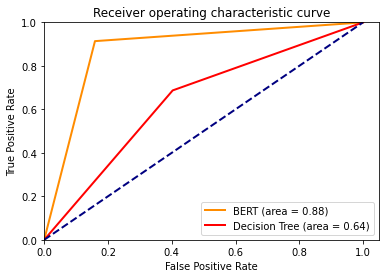

<Figure size 432x288 with 0 Axes>

In [177]:
fig, ax = plt.subplots()
plt.figure()
lw = 2
ax.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="BERT (area = %0.2f)" % roc_auc,
)
ax.plot(
    fpr_base,
    tpr_base,
    color="red",
    lw=lw,
    label="Decision Tree (area = %0.2f)" % roc_auc_base,
)
ax.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
ax.set_ylim([0.0, 1.0])
ax.set_xlim([0.0, 1.05])
ax.set_ylabel("True Positive Rate")
ax.set_xlabel("False Positive Rate")
ax.set_title("Receiver operating characteristic curve")
ax.legend(loc="lower right")
fig.savefig('figures/claim_stance_roc_auc.png', transparent=True, dpi = 800, bbox_inches='tight');

## Dataset #4: Debater analysis

In [7]:
dataset_arg_gen_ootec.head()

,motion-id,motion,set
0,121,We should ban boxing,Test
1,3162,We should adopt multiculturalism,Train
2,2489,We should abolish no-knock warrants,Train
3,2109,We should cancel the Social Security tax,Test
4,3164,We should abolish open primaries in the United...,Test


In [6]:
dataset_arg_gen_args.head()

,argument
0,"We should abolish juvenile courts.\nSo, we're ..."
1,Okay so side government tells us that there's ...
2,We should protect edward snowden.\nIn this rou...
3,I'm proud to stand in opposition of the motion...
4,We should not privatize water.\nSo the other s...


## Dataset #5: Key point analysis

In [8]:
dataset_key_point.head()

,topic,argument,key_point,stance,label
0,Assisted suicide should be a criminal offence,`people reach their limit when it comes to the...,Assisted suicide gives dignity to the person t...,-1,0
1,Assisted suicide should be a criminal offence,a cure or treatment may be discovered shortly ...,Assisted suicide allows people to solicit some...,1,0
2,Assisted suicide should be a criminal offence,a cure or treatment may be discovered shortly ...,Assisted suicide is akin to killing someone,1,0
3,Assisted suicide should be a criminal offence,a cure or treatment may be discovered shortly ...,Assisted suicide should not be allowed because...,1,1
4,Assisted suicide should be a criminal offence,a cure or treatment may be discovered shortly ...,Assisted suicide violates the doctor's role,1,0


## Dataset #6: Argument generation

In [9]:
dataset_claim_gen.head()

,prefix,topic,text,set,model,plausibility_score,plausibility_label,stance_conf,stance_label,combined_label
0,Begging should be banned,Begging should be banned,"""Begging"" is a form of child abuse and should ...",test,GPT-2-LN-FWS,0.714286,Yes,1.0,Pro,1
1,Begging should be banned,Begging should be banned,beg is a disgusting way to treat animals. it ...,test,GPT-2-RANK,0.000000,No,NaN,NaN,0
2,Begging should be banned,Begging should be banned,Begging is the cause of so many child abuse c...,test,GPT-2-RANK,0.428571,No,NaN,NaN,0
3,Begging should be banned,Begging should be banned,Begging is a crime against humanity.,test,GPT-2-LN-FWS,0.857143,Yes,1.0,Pro,1
4,Begging should be banned,Begging should be banned,Begging is a drain on society.,test,GPT-2-LN-FWS,0.714286,Yes,1.0,Pro,1
